# Case 3. Medical text categorization
Ville Seeste<br>
Last edited: 12.03.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

Goal of this exercise was to categorize medical text data and get to know basics of how to deal with text related machine learning problems. 

## 2. Required libraries and global variables

In [229]:
import os
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical
import time
import matplotlib.pyplot as plt
import re

## 3. Data description and preprocessing

In text preprocessing my plan was to remove as many unnecassery words as possible. For example removing most common words and stopwords. Also I removed numbers and special characters.

### Get data from the directories

In [230]:
ohsumed_dir = 'ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')
test_dir = os.path.join(ohsumed_dir, 'test')

labels = []
texts = []
test_labels = []
test_texts = []

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]

# Training data
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    #print(label_type, len(os.listdir))
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)

# Test data
for label_type in L:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        test_labels.append(L.index(label_type))



### Obtaining most common words

In [231]:
maxlen = 250 #250 best so far
max_words = 10000 # 10 000 best so far
eDim = 256

tokenizer = Tokenizer(num_words=max_words, lower=True, filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(texts)

most_common_words = []
word_index = tokenizer.word_index

# add most common words to array
i = 1
remove_amount = 46 # 46 best at the moment
while i < remove_amount:
    most_common_words.append(list(word_index.keys())[list(word_index.values()).index(i)])
    i = i + 1


sequences = tokenizer.texts_to_sequences(texts)

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = np.asarray(test_labels)
y_test = to_categorical(test_labels)


print('Found %s unique tokens' % len(word_index))

Found 28665 unique tokens


### Removing some words

In this part I removed most common word obtained previosly and also some stopwords. NLTK library migth have some good functions for this but I did my own script for this because I am dumb... It works pretty well althougt it removes more words than I wanted, but I think it's not a major issue if it looses couple words here and there (for classification purposes).

In [232]:
texts_no_common = []
replace_amount = 0
no_replace = 0
stop_counter = 0

# Stop word list
stop_words = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", 
              "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", 
              "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be",
              "became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below",
              "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant",
              "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each",
              "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every",
              "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first",
              "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give",
              "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon",
              "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed",
              "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd",
              "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move",
              "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no",
              "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one",
              "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part",
              "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious",
              "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
              "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the",
              "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein",
              "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through",
              "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un",
              "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
              "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether",
              "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without",
              "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]

for text in texts:
    
    # Filter unwanted characters
    text = text.lower()
    text = re.sub('[^a-z ]', ' ', text)
    
    #split words to list
    words = text.split()
    new_words = []
    
    # this part removes most common words
    for word in words:
        valid_word = True
        for common in most_common_words:
            if word == common:
                valid_word = False
                replace_amount = replace_amount + 1                
                break
                
        if valid_word:
            #check if word is a stop word
            for stpwrd in stop_words:
                if word == stpwrd:
                    stop_counter = stop_counter + 1
                    valid_word = False
                    break
        if valid_word:
            no_replace = no_replace + 1
            new_words.append(word)
            
    # Make to string again and add to list
    sentence = ' '.join(new_words)
    texts_no_common.append(sentence)

tok = Tokenizer(num_words=max_words, lower=True, filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tok.fit_on_texts(texts_no_common)
word_index_no_common = tok.word_index
sequences2 = tok.texts_to_sequences(texts_no_common)

print('Found %s unique tokens' % len(word_index_no_common))
print("Keeped words: " + str(no_replace) + "\nRemoved words: " + str(replace_amount) + "\nRemoved stop words: " + str(stop_counter))

Found 28041 unique tokens
Keeped words: 1009839
Removed words: 642023
Removed stop words: 106240


#### prepare for training

In [233]:
#data = pad_sequences(sequences, maxlen = maxlen)
data = pad_sequences(sequences2, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)

print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 250)
Shape of labels tensor: (10433, 23)


In [234]:
# Suffle data

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

## 4. Modeling and compilation

I tested many different kind of model but this one seemed to work the best. So I have couple 1D convolutional layers at the base of the model. Then I have LSTM layer (I tried to stack 2 but there was not much difference in result) and softmax layer. I use dropouts in LSTM layers to decrease overfitting.

In [235]:
model = Sequential()
model.add(Embedding(max_words, eDim, input_length=maxlen))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 7, activation='relu'))
#model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 250, 256)          2560000   
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 244, 64)           114752    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 48, 64)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 42, 64)            28736     
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_23 (Dense)             (None, 23)                759       
Total params: 2,716,663
Trainable params: 2,716,663
Non-trainable params: 0
_________________________________________________________________


## 5. Training

Training was pretty fast (compared to case 2). 

In [236]:
t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 5,
                   batch_size = 32,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/5
8346/8346 [==============================] - 62s 7ms/step - loss: 2.7059 - acc: 0.2124 - val_loss: 2.5424 - val_acc: 0.2750
Epoch 2/5
8346/8346 [==============================] - 57s 7ms/step - loss: 2.4149 - acc: 0.2955 - val_loss: 2.4759 - val_acc: 0.2918
Epoch 3/5
8346/8346 [==============================] - 52s 6ms/step - loss: 2.2182 - acc: 0.3393 - val_loss: 2.4470 - val_acc: 0.2894
Epoch 4/5
8346/8346 [==============================] - 51s 6ms/step - loss: 2.0547 - acc: 0.3777 - val_loss: 2.4559 - val_acc: 0.2894
Epoch 5/5
8346/8346 [==============================] - 51s 6ms/step - loss: 1.9140 - acc: 0.4153 - val_loss: 2.5317 - val_acc: 0.2674
Elapsed time: 274.99 seconds


## 6. Validation

My model started to overfit very quickly, usually after 3 epochs. Validation accuracy was usually between 28-30%.

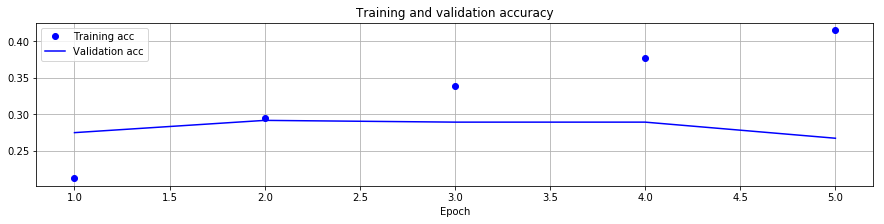

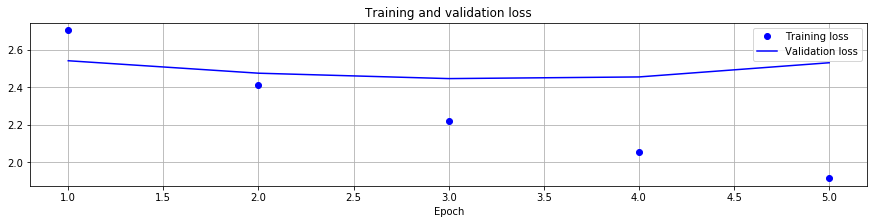

In [237]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 7. Results and Discussion

Without preprocessing my accuracy was below 20%. Only with filtering numbers, my accuracy increased about 5%. With removing most common words my accuracy reached around 30%. Removing stopwords didn't help much with the accuracy. I was a bit surprised how much you can improve your accuracy just by preprocessing text. 

In [238]:
# Preprocess test data

test_texts_no_common = []

for text in test_texts:
    
    # Filter unwanted characters
    text = text.lower()
    text = re.sub('[^a-z ]', ' ', text)
    
    #split words to list
    words = text.split()
    new_words = []
    
    # this part removes most common words
    for word in words:
        valid_word = True
        for common in most_common_words:
            if word == common:
                valid_word = False
                break
                
        if valid_word:
            #check if word is a stop word
            for stpwrd in stop_words:
                if word == stpwrd:
                    valid_word = False
                    break
        if valid_word:
            new_words.append(word)
            
    # Make to string again and add to list
    sentence = ' '.join(new_words)
    test_texts_no_common.append(sentence)



In [241]:
test_sequences = tok.texts_to_sequences(test_texts_no_common)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = np.asarray(test_labels)
y_test = to_categorical(test_labels)

print('Found %s unique tokens' % len(word_index_no_common))

Found 28041 unique tokens


In [242]:
model.evaluate(x_test, y_test)

12733/12733 [==============================] - 18s 1ms/step


[2.325254727353625, 0.3193277311228642]

## 8. Conclusions

I found out that it's rather difficult to train models to understand text. Even in this pretty simple classification task it was hard to reach good results. 

Also I realized the importance of preprocessing the data to achieve good results.